In [1]:
from QHyper.problems.community_detection import Network, CommunityDetectionProblem
import networkx as nx

# Important remarks

The general experiment we wanted to conduct was to run hierarchical search with Gurobi instead of Advantage.
This was to be done to check which component (hierarchical or quantum) to "blame" for the high percentage of obtained "zero" modularity scores in our hierarchical-quantum approach
(in our previous experiments we usually obtained a lot of zero modularity scores).

However after having added and used Gurobi in the hierarchical approach a new issue was discovered - it returned a lot of zeros as well, **but** for some other (implemenation) reason.

### Load prepared sample networks
Powerlaw graph family, range of number of nodes [10, 20, ..., 100] prepared for the demonstration.

In [32]:
import numpy as np


Graphs = np.load("graphs.npy", allow_pickle=True)

num_nodes = [g.number_of_nodes() for g in Graphs]
num_nodes

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

### Let's test Hierarchical Search with Gurobi

The purpose of what we have talked about last week was to compare hierarchical-quantum approach (hierarchical + Advantage) with hierarchical-nonadvantage approach (hierarchical + ex. Gurobi)
to prove (or not, or gain more prior at least) which component of our approach is responsible for getting a lot of 0 modularity scores.

Our intuition was that it was Advantage. And that is probably true, HOWEVER, another zero-modularity-score-producing issue was discovered.

So this notebook's purpose isn't to compare (hierarchical + Gurobi) with (hierarchical + Advantage) - not yet! - but to present the new issue.

That is why I will be using LeidenSampler as a reference method - as, as other classical samplers, it produces "stable" (always non-zero modularity-scores) partitioning results.

In [3]:
from Qommunity.samplers.hierarchical.gurobi_sampler import GurobiSampler
from Qommunity.searchers.hierarchical_community_searcher import HierarchicalCommunitySearcher

from Qommunity.samplers.regular.leiden_sampler import LeidenSampler
from Qommunity.searchers.community_searcher import CommunitySearcher

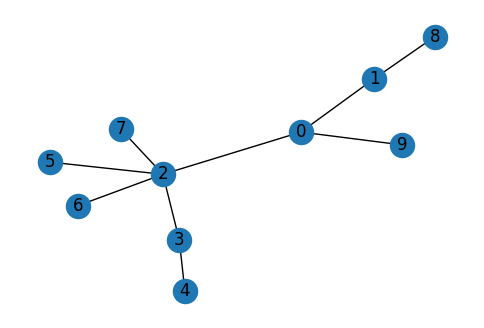

In [14]:
import matplotlib.pyplot as plt


f, ax = plt.subplots(1, figsize=(6, 4))

G = Graphs[0]
nx.draw(G, with_labels=True, ax=ax)

Added custom supress_output flag because Gurobi produces a lot of output - just so that you won't be surprised there's no output with Gurobi running underneath

In [19]:
# supress_output=False
gurobi = GurobiSampler(G, supress_output=False)
hierch_searcher = HierarchicalCommunitySearcher(gurobi)
res_gurobi = hierch_searcher.hierarchical_community_search()
res_gurobi

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 10 columns and 0 nonzeros
Model fingerprint: 0xd03a2991
Model has 55 quadratic objective terms
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e-01, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Found heuristic solution: objective -3.2777778
Presolve removed 0 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: -3.27778 0 
No other solutions better than -3.27778

Optimal s

[[2, 5, 6, 7], [3, 4], [0, 1, 8, 9]]

In [21]:
# supress_output=True
gurobi = GurobiSampler(G, supress_output=True)
hierch_searcher = HierarchicalCommunitySearcher(gurobi)
res_gurobi = hierch_searcher.hierarchical_community_search()
res_gurobi

[[2, 5, 6, 7], [3, 4], [0, 1, 8, 9]]

### Let's get to see some runs
### 1. Simple case - 1 run per each graph

In [22]:
comms_leiden = []
comms_gurobi = []

mods_leiden = []
mods_gurobi = []
for G in Graphs:
    leiden = LeidenSampler(G)
    searcher = CommunitySearcher(leiden)
    res_leiden = searcher.community_search()

    gurobi = GurobiSampler(G, supress_output=True)
    hierch_searcher = HierarchicalCommunitySearcher(gurobi)
    res_gurobi = hierch_searcher.hierarchical_community_search()

    comms_leiden.append(res_leiden)
    comms_gurobi.append(res_gurobi)

    mod_score_leiden = nx.community.modularity(G, res_leiden)
    mod_score_gurobi = nx.community.modularity(G, res_gurobi)

    mods_leiden.append(mod_score_leiden)
    mods_gurobi.append(mod_score_gurobi)

In [28]:
np.isclose(np.array(mods_gurobi), np.array(mods_leiden))

array([ True,  True,  True,  True,  True, False,  True, False,  True,
        True])

Not all partitionings, were the same, but generally similar, that's not the point for now anyway...

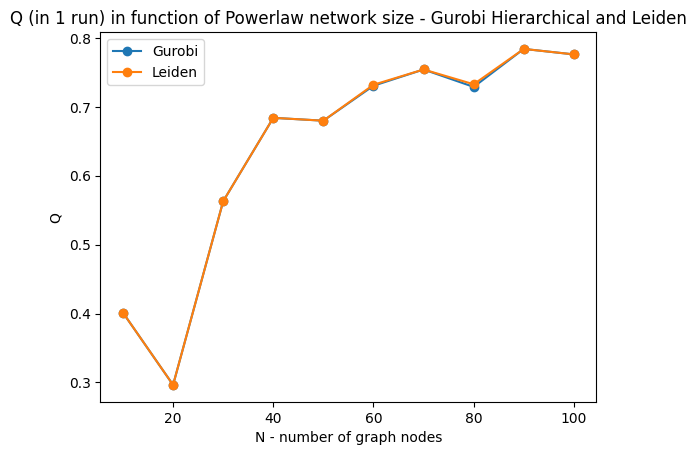

In [37]:
from matplotlib import pyplot as plt


fig, ax = plt.subplots(1)
plt.plot(num_nodes, mods_gurobi, '-o', label="Gurobi")
plt.plot(num_nodes, mods_leiden, '-o', label="Leiden")
plt.legend()
ax.set_title("Q (in 1 run) in function of Powerlaw network size - Gurobi Hierarchical and Leiden");
ax.set_xlabel("N - number of graph nodes");
ax.set_ylabel("Q");

### 2. Run N times
##### In this example N = 10. I did run it for N = 50 before, but running hierarchical approach with Gurobi 50 times for a big graph (num. of nodes >= 80) took a lot of time - Gurobi is precise and takes time for such big problems. But N = 10 is enough to show:

In [77]:
import os


dir = "gurobi_test_results/one_instance"
os.makedirs(os.path.dirname(dir+"/"), exist_ok=True)


def make_dir(dir):
    if not os.path.exists(dir):
        os.mkdir(dir)

#### Gurobi first

In [78]:
solver = "gurobi"
make_dir(f"{dir}/{solver}")

In [79]:
# to recall what num_nodes was
# num_nodes = [g.number_of_nodes() for g in Graphs]
num_nodes = np.linspace(10, 100, 10)
num_nodes

array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.])

In [80]:
from tqdm import tqdm


N_RUNS = 10


mods = np.zeros((num_nodes.shape[0], N_RUNS))
comms = np.empty((num_nodes.shape[0], N_RUNS), dtype=object)

mods_graph_N = np.zeros((N_RUNS))
comms_graph_N = np.empty((N_RUNS), dtype=object)
for i, G in tqdm(enumerate(Graphs)):
    gurobi = GurobiSampler(G, supress_output=True)
    hierch_searcher = HierarchicalCommunitySearcher(gurobi)
    
    for r in range(N_RUNS):
        comms_res = hierch_searcher.hierarchical_community_search()
        mod_score = nx.community.modularity(G, comms_res)
        mods_graph_N[r] = mod_score
        comms_graph_N[r] = comms_res

    current_net_size = int(num_nodes[i])
    mods[i] = mods_graph_N
    comms[i] = comms_graph_N
    np.save(f"{dir}/{solver}/network_size_{current_net_size}", mods_graph_N)
    np.save(f"{dir}/{solver}/network_size_{current_net_size}_comms", comms_graph_N)

np.save(f"{dir}/{solver}/mods_final", mods)
np.save(f"{dir}/{solver}/comms_final", comms)

10it [00:06,  1.66it/s]


#### Now the same for Leiden

In [81]:
solver = "leiden"
make_dir(f"{dir}/{solver}")

In [82]:
from tqdm import tqdm


N_RUNS = 10


mods = np.zeros((num_nodes.shape[0], N_RUNS))
comms = np.empty((num_nodes.shape[0], N_RUNS), dtype=object)

mods_graph_N = np.zeros((N_RUNS))
comms_graph_N = np.empty((N_RUNS), dtype=object)
for i, G in tqdm(enumerate(Graphs)):
    leiden = LeidenSampler(G)
    searcher = CommunitySearcher(leiden)
    
    for r in range(N_RUNS):
        comms_res = searcher.community_search()
        mod_score = nx.community.modularity(G, comms_res)
        mods_graph_N[r] = mod_score
        comms_graph_N[r] = comms_res

    current_net_size = int(num_nodes[i])
    mods[i] = mods_graph_N
    comms[i] = comms_graph_N
    np.save(f"{dir}/{solver}/network_size_{current_net_size}", mods_graph_N)
    np.save(f"{dir}/{solver}/network_size_{current_net_size}_comms", comms_graph_N)

np.save(f"{dir}/{solver}/mods_final", mods)
np.save(f"{dir}/{solver}/comms_final", comms)

10it [00:00, 130.38it/s]


Let's see the results

In [83]:
mods_gurobi = np.load(f"{dir}/gurobi/mods_final.npy")
mods_leiden = np.load(f"{dir}/leiden/mods_final.npy")

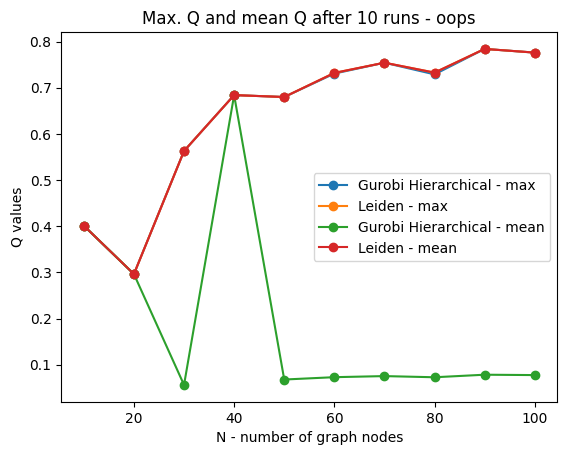

In [84]:
from matplotlib import pyplot as plt


fig, ax = plt.subplots(1)
plt.plot(num_nodes, mods_gurobi.max(axis=-1), '-o', label="Gurobi Hierarchical - max")
plt.plot(num_nodes, mods_leiden.max(axis=-1), '-o', label="Leiden - max")
plt.plot(num_nodes, mods_gurobi.mean(axis=-1), '-o', label="Gurobi Hierarchical - mean")
plt.plot(num_nodes, mods_leiden.mean(axis=-1), '-o', label="Leiden - mean")
plt.legend()
ax.set_title("Max. Q and mean Q after 10 runs - oops");
ax.set_xlabel("N - number of graph nodes");
ax.set_ylabel("Q values");

In [85]:
np.isclose(mods_gurobi, np.zeros(mods_gurobi.shape))

array([[False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False,  True,  True,  True,  True,  True,  True,  True,  True,
         True]])

## As can be seen, an issue has been discovered - our hierarchical method produces a lot of zeros - when run with the same instances of HierarchicalSamplers on the same instances of HierarchicalSearcher multiple times (multiple runs).
Why is that? Reason -> 
https://github.com/kacper3615/Qommunity/blob/204014ae872e33e29bd60fc441664acf36d98792/Qommunity/searchers/hierarchical_community_searcher/hierarchical_community_searcher.py#L153
and 
https://github.com/kacper3615/Qommunity/blob/204014ae872e33e29bd60fc441664acf36d98792/Qommunity/searchers/hierarchical_community_searcher/hierarchical_community_searcher.py#L134
Reiniting the sampler when level is not 1 -> every new .hierarchical_search() method call makes sure level is 1 and "community" is None, so the new community value is produced, but it is not used (sampler with that community is not reinited), so the new run of our hierarchical recursion method is run with previous community value remembered inside the sampler (community is used inside sampler, when creating the Network class passed later to CommunitDetectionProblem class passed later to QHyper.Advantage or QHyper.Gurobi).

To see that's the case let's run with new instance of hierarchical sampler and hierarchical searcher each time:

### 3. Run N times - with new instance of hierarchical searcher each time
When running it N = 10 times, you won't notice the time difference when creating new instance each time. However, when I ran it N = 50 times before, the time difference was significant - that's obviously because now our approach will be calculated properly - vs. before, when the calcuations would stop too early, resulting in modularity score of 0 (no partitioning - returning immediately with 1 community only).

In [86]:
import os


dir = "gurobi_test_results/multiple_instances"
os.makedirs(os.path.dirname(dir+"/"), exist_ok=True)


def make_dir(dir):
    if not os.path.exists(dir):
        os.mkdir(dir)

#### Gurobi

In [87]:
solver = "gurobi"
make_dir(f"{dir}/{solver}")

In [88]:
from tqdm import tqdm


N_RUNS = 10


mods = np.zeros((num_nodes.shape[0], N_RUNS))
comms = np.empty((num_nodes.shape[0], N_RUNS), dtype=object)

mods_graph_N = np.zeros((N_RUNS))
comms_graph_N = np.empty((N_RUNS), dtype=object)
for i, G in tqdm(enumerate(Graphs)):    
    for r in range(N_RUNS):
        # this time, new instance each time
        gurobi = GurobiSampler(G, supress_output=True)
        hierch_searcher = HierarchicalCommunitySearcher(gurobi)
        comms_res = hierch_searcher.hierarchical_community_search()
        
        mod_score = nx.community.modularity(G, comms_res)
        mods_graph_N[r] = mod_score
        comms_graph_N[r] = comms_res

    current_net_size = int(num_nodes[i])
    mods[i] = mods_graph_N
    comms[i] = comms_graph_N
    np.save(f"{dir}/{solver}/network_size_{current_net_size}", mods_graph_N)
    np.save(f"{dir}/{solver}/network_size_{current_net_size}_comms", comms_graph_N)

np.save(f"{dir}/{solver}/mods_final", mods)
np.save(f"{dir}/{solver}/comms_final", comms)

10it [00:48,  4.81s/it]


#### Took more time, because now the partitionings have been calculated properly - the differences would be huge only for big graphs (90-100 nodes) and big Ns (N=50)

#### Re-run for leiden - but that won't make any difference, there is no such issue in the RegularSearcher.community_search() method

In [89]:
solver = "leiden"
make_dir(f"{dir}/{solver}")

In [90]:
from tqdm import tqdm


N_RUNS = 10


mods = np.zeros((num_nodes.shape[0], N_RUNS))
comms = np.empty((num_nodes.shape[0], N_RUNS), dtype=object)

mods_graph_N = np.zeros((N_RUNS))
comms_graph_N = np.empty((N_RUNS), dtype=object)
for i, G in tqdm(enumerate(Graphs)):
    leiden = LeidenSampler(G)
    searcher = CommunitySearcher(leiden)
    
    for r in range(N_RUNS):
        comms_res = searcher.community_search()
        mod_score = nx.community.modularity(G, comms_res)
        mods_graph_N[r] = mod_score
        comms_graph_N[r] = comms_res

    current_net_size = int(num_nodes[i])
    mods[i] = mods_graph_N
    comms[i] = comms_graph_N
    np.save(f"{dir}/{solver}/network_size_{current_net_size}", mods_graph_N)
    np.save(f"{dir}/{solver}/network_size_{current_net_size}_comms", comms_graph_N)

np.save(f"{dir}/{solver}/mods_final", mods)
np.save(f"{dir}/{solver}/comms_final", comms)

10it [00:00, 124.18it/s]


### The results again

In [92]:
mods_gurobi_2 = np.load(f"{dir}/gurobi/mods_final.npy")
mods_leiden_2 = np.load(f"{dir}/leiden/mods_final.npy")

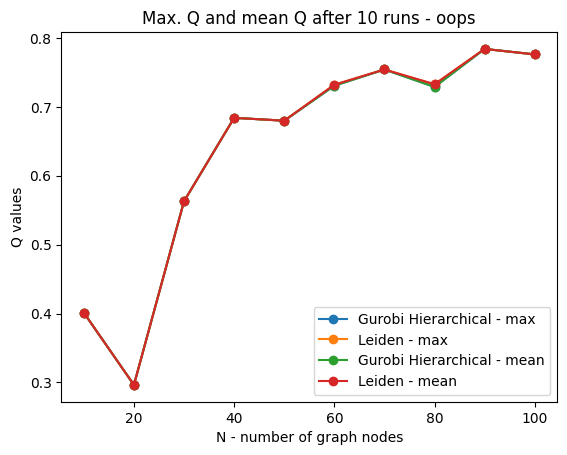

In [93]:
from matplotlib import pyplot as plt


fig, ax = plt.subplots(1)
plt.plot(num_nodes, mods_gurobi_2.max(axis=-1), '-o', label="Gurobi Hierarchical - max")
plt.plot(num_nodes, mods_leiden_2.max(axis=-1), '-o', label="Leiden - max")
plt.plot(num_nodes, mods_gurobi_2.mean(axis=-1), '-o', label="Gurobi Hierarchical - mean")
plt.plot(num_nodes, mods_leiden_2.mean(axis=-1), '-o', label="Leiden - mean")
plt.legend()
ax.set_title("Max. Q and mean Q after 10 runs - oops");
ax.set_xlabel("N - number of graph nodes");
ax.set_ylabel("Q values");

In [96]:
np.isclose(mods_gurobi_2, np.zeros(mods_gurobi_2.shape)).any()

False

# Now everything looks as it's supposed to.
Suggestion on how to fix or omit this issue:
1. Fix - Update code
https://github.com/kacper3615/Qommunity/blob/204014ae872e33e29bd60fc441664acf36d98792/Qommunity/searchers/hierarchical_community_searcher/hierarchical_community_searcher.py#L153
so that the sampler is always reinited

or

2. Omit - make sure the user always uses a new instance of the hierarchical sampler and hierarchical searcher (ensure it some other way).

(I am for option 1.)

### Once having ensured that we are always having a reininted sampler and setting the proper num_reads parameter to Advantage, we'll be able to answer the question what is responsible for our modularity zeros (by comparing hierarchical Advantage with hierarchical Gurobi).

Conclusions:
- as a part-time solution make sure to always! create a new instance of the hierarchical sampler and the hierarchical searcher for the hierarchical method!
- make sure to set proper value of num_reads.